# Analisis de Dots and Boxes

## Explicación juego
El juego de dots and boxes se juega de a 2 jugadores en una cuadricula $m \times n $ en donde se pueden unir vertices o puntos horizontal o verticalmente con otro inmediato.  
Los jugadores se turnan uniendo puntos, a medida que un jugador cree una caja (una 4 vertices formando un cuadrado) se le asigna un punto <s>y puede poner otra linea</s>. El juego acaba cuando ya no falten aristas por generar y el ganador es el jugador con mayor puntaje

## Implementacion

Se considera un sistema coordenado con el origen _(0, 0)_ en la esquina superior izquierda (al igual que la mayoria de las interfaces graficas) siendo x de izquierda a derecha; y **y** de arriba a abajo.



### Box

Representa una casilla del juego, con 4 esquinas y 4 aristas. Cada esquina contiene coordenadas, con la caracteristica que las cordenadas de los puntos de arriba tienen una diferencia de 1 en el valor de la **X**, mientras la diferencia de los puntos a los lados es una differencia de 1 en el valor de la **y**. Las aristas estan compuestas por 2 de estas coordenadas

|     |     |     |
|:---:|:---:|:---:|
|        $ (x, y) $        |     $ ((x, y), (x + 1, y)) $     |          $ (x + 1, y) $          |
| $((x, y), (x, y + 1)) $  |                                  | $ ((x + 1, y), (x + 1, y + 1)) $ |
|      $ (x, y + 1) $      | $ ((x, y + 1), (x + 1, y + 1)) $ |        $ (x + 1, y + 1) $        |

Tambien hay banderas indicando si una arista esta puesta o no

```mermaid
classDiagram
    class Box {
        TopLine
        LeftLine
        RightLine
        BottomLine
        owner
        bool completed

        bool connect(coordinates)
    }
```


### Board

Se modela el tablero, con dimensiones $m \times n$. Se tiene una matriz de `Box`es. Tambien se tienen unos conjuntos de vectores (tuple de coordenadas de inicio y fin):
- `_open_vectors` representa los vectores que aun se pueden poner. En otras palabras, representa todas las posibles jugadas disponibles
- `_connected_vectors` representa todas las jugadas que se han hecho.

Las cajas comparten ejes por lo que cuando se agrega una linea, esta se pone en las 2 cajas.

```mermaid
classDiagram

    class Board {
        int player_score
        int ai_score
        int m
        int n
        Box[][] _boxes
        _open_vectors
        _connected_vectors

        move(coordinates, player_move = False)
        bool has_moves()

        get_available_moves()
    }
```

### GameManager

Es la entidad encargada el juego, aplica las jugadas que realice el jugador al tablero y genera genera la siguiente.
Tiene los siguientes parametros:
- `m` la cantidad de columnas
- `n` la cantidad de filas
- `level` la profunidad que va a mirar dentro del arbol
- `mode` como va a realizar el arbol (acepta `minimax` o `alphabeta`)

Metodos:
- `get_move(origin, dest)`: aplica la jugada del jugador al tablero y realiza la siguiente de acuerdo al arbol. Tanto `origin` como `dest` son tuplas `(x, y)`
- `evaluate(state: Board)`: evalua el estado

## Analisis

Se realizo un analisis del comportamiento del arbol con el fin de entender su relación con el tiempo que se demora en procesar el siguiente movimiento.

El numero de posibles movimientos iniciales para un tablero $m \times n $ es:  
$ N_i = m \times \left(n + 1\right) + \left(m + 1\right) \times n $

A una profundidad $d$ se habran hecho $d$ jugadas lo que significa que las jugadas aun disponibles son $ N - d $.  
El numero de diferentes estados que se pueden tener a una profundidad $d$ se puede representar con un coeficiente binomial (o combinatoria)

$ C_{d}^{\lambda} = \binom{\lambda}{d} = \frac{\lambda!}{d!\left(\lambda - d\right)!} $ Con $\lambda$ siendo el numero de aristas libres o movimientos disponibles.  
Este valor representaria todas las hojas unicas del arbol a la profundidad $d$.

Para obtener todas las hojas del arbol se utiliza

$ P_{\lambda}^{d} = \frac{\lambda!}{\left(\lambda - d\right)!} $

Para obtener todos los posibles estados, nodos, unicos hasta cierta profundidad $d$, se necesita hacer suma de los coeficientes binomiales (combinatorias) para cada profundidad desde $0$ hasta $d$

$
S_{c,d} = \sum_{k=0}^{d}\left({C_{k}^{N}}\right)
$

Para obtener todos los nodos del arbol:

$
S_{p,d} = \sum_{k=0}^{d}\left({P_{k}^{N}}\right)
$

> Por ejemplo, un tablero $2 \times 2$  
- $ m = 2, n = 2 $  
- $ N = 12 $  

| profundidad (d) | Todos Estados hasta unicos d | Todos los Estados |
| ------------|---|-----------|
| 0 | $ \binom{12}{0} = 1 $ | $ P_{0}^{12} = 1 $ |
| 1 | $ \binom{12}{01} + \binom{12}{1} = 1 + 12 = 13 $ | $ P_{0}^{12} + P_{1}^{12} = 1 + 12 = 13$ |
| 2 | $ \binom{12}{01} + \binom{12}{1} + \binom{12}{1} = 1 + 12 + 66 = 79 $ | $ P_{0}^{12} + P_{1}^{12} + P_{2}^{12} = 1 + 12 + 132 = 145$ |

In [47]:
import math
import matplotlib.pyplot as plt
import numpy as np

def total_unique_states_depth(n, d):
    sc = 0
    for k in range(0, d + 1):
        sc += math.comb(n, k)
    return sc

def total_states_depth(n, d):
    sp = 0
    for k in range(d + 1):
        sp += math.perm(n, k)
    return sp

m = 5
n = 5
d = 10

N = m * (n + 1) + (m + 1) * n
print("Total states:", N)

SP = total_states_depth(N, d)
print("SP:", SP)

Total states: 60
SP: 279059500828581601


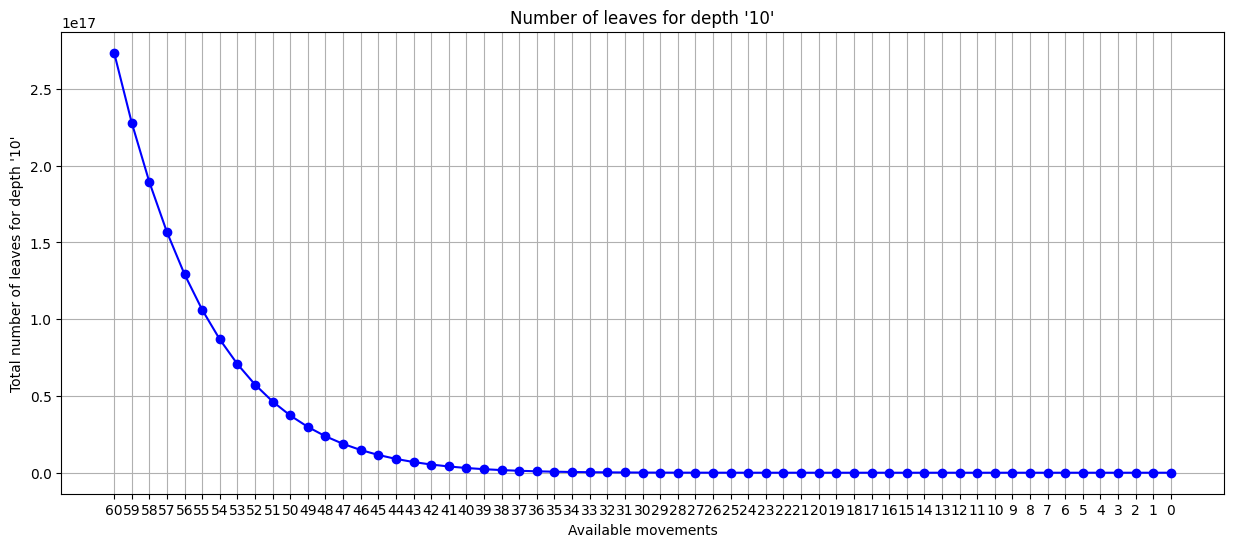

In [90]:
elements = range(N + 1)
states = [math.perm(n, d) for n in elements]
# print(states[-1])

plt.figure(figsize=(15, 6))
plt.plot(elements, states, marker='o', linestyle='-', color='b')
plt.gca().invert_xaxis()
plt.xlabel('Available movements')
plt.ylabel(f"Total number of leaves for depth '{d}'")
# plt.title(f'Numer of Leaves for each Play of {N} Edges at Depth {d}')
plt.title(f"Number of leaves for depth '{d}'")
plt.grid(True)
plt.xticks(elements)
plt.show()

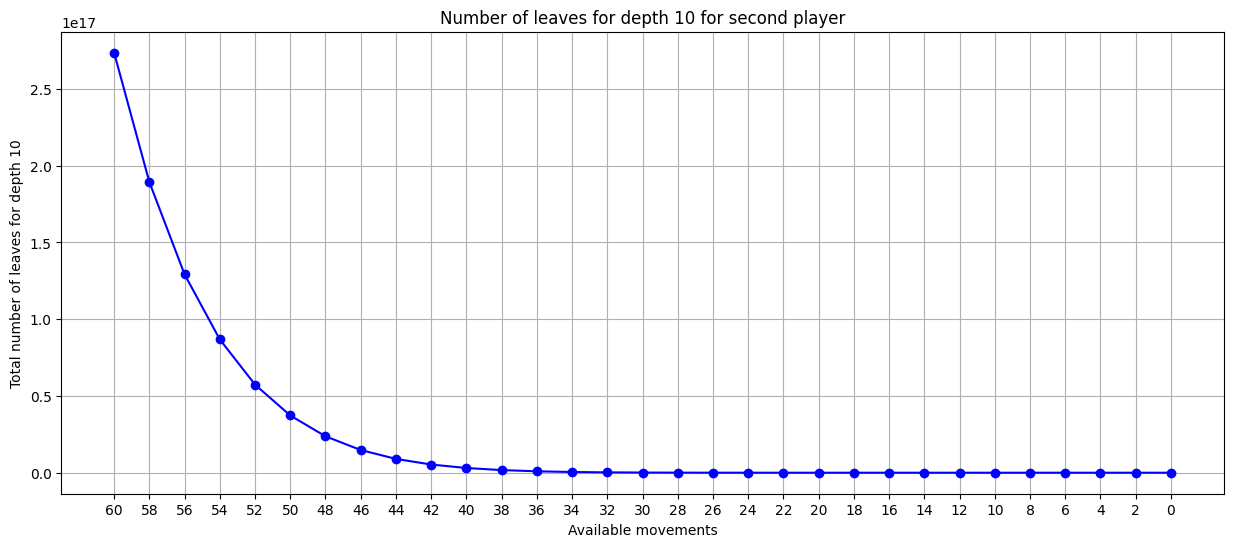

In [89]:
elements = range(0, N + 1, 2)
states = [math.perm(n, d) for n in elements]
# print(states[-1])

plt.figure(figsize=(15, 6))
plt.plot(elements, states, marker='o', linestyle='-', color='b')
plt.gca().invert_xaxis()
plt.xlabel('Available movements')
plt.ylabel(f"Total number of leaves for depth '{d}'")
# plt.title(f'Numer of Leaves for each Play of {N} Edges at Depth {d}')
plt.title(f"Number of leaves for depth '{d}' for second player")
plt.grid(True)
plt.xticks(elements)
plt.show()

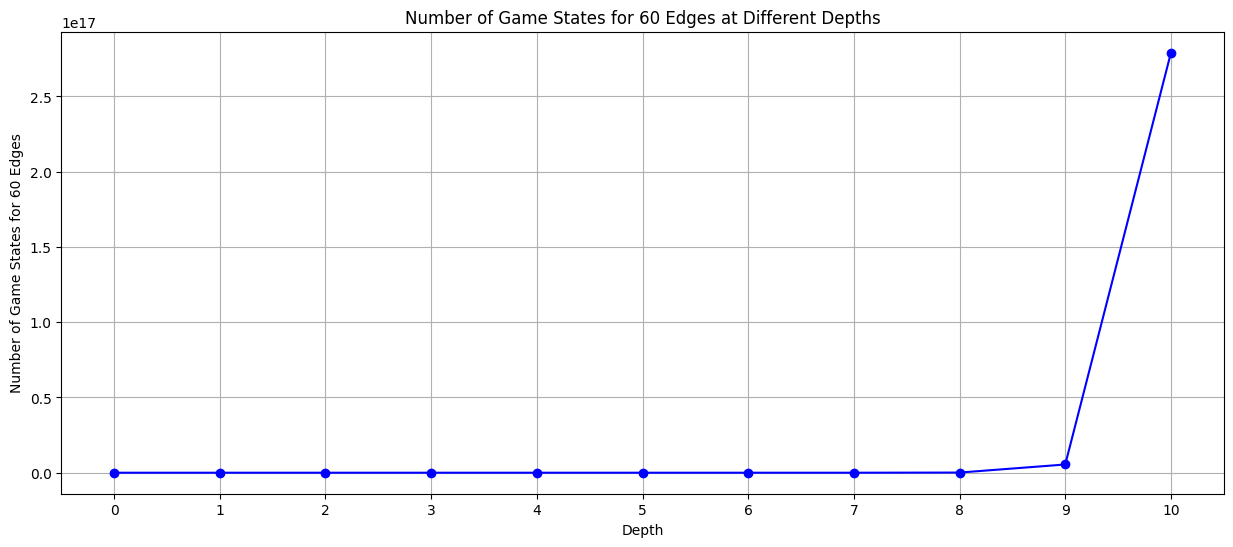

In [79]:
depths = range(d + 1)
states_at_depth = [total_states_depth(N, d) for d in depths]

plt.figure(figsize=(15, 6))
plt.plot(depths, states_at_depth, marker='o', linestyle='-', color='b')
plt.xlabel('Depth')
plt.ylabel(f'Number of Game States for {N} Edges')
plt.title(f'Number of Game States for {N} Edges at Different Depths')
plt.grid(True)
plt.xticks(depths)
plt.show()

In [75]:
total_states_depth(N, d) - math.perm(N, d)

5469653597080801

279059500828581601


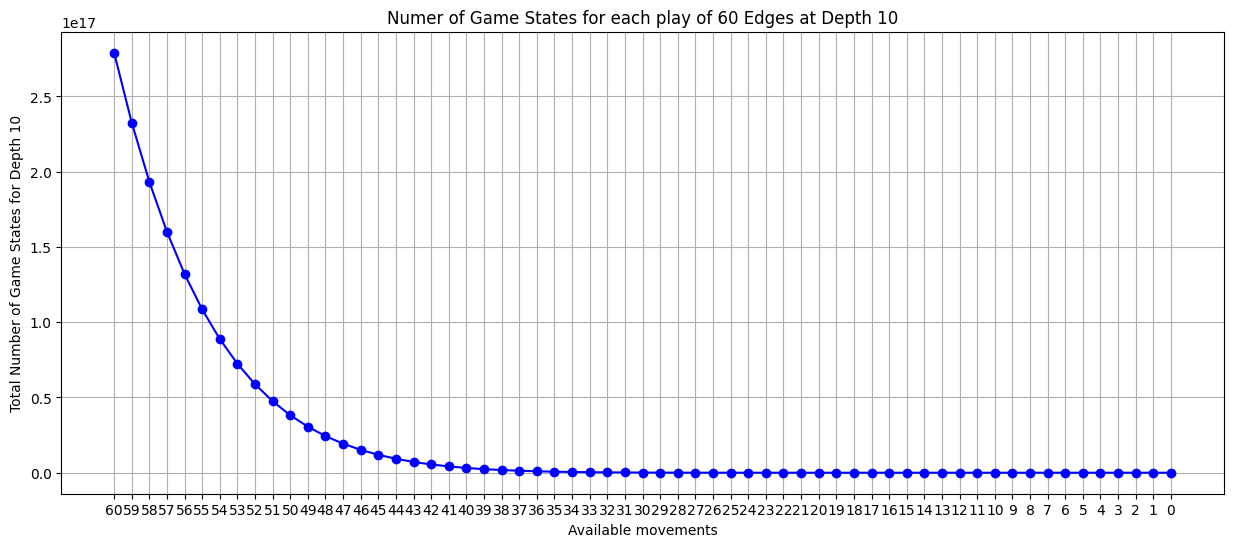

In [80]:
elements = range(N + 1)
states = [total_states_depth(n, d) for n in elements]

print(states[-1])

plt.figure(figsize=(15, 6))
plt.plot(elements, states, marker='o', linestyle='-', color='b')
plt.gca().invert_xaxis()
plt.xlabel('Available movements')
plt.ylabel(f'Total Number of Game States for Depth {d}')
plt.title(f'Numer of Game States for each play of {N} Edges at Depth {d}')
plt.grid(True)
plt.xticks(elements)
plt.show()

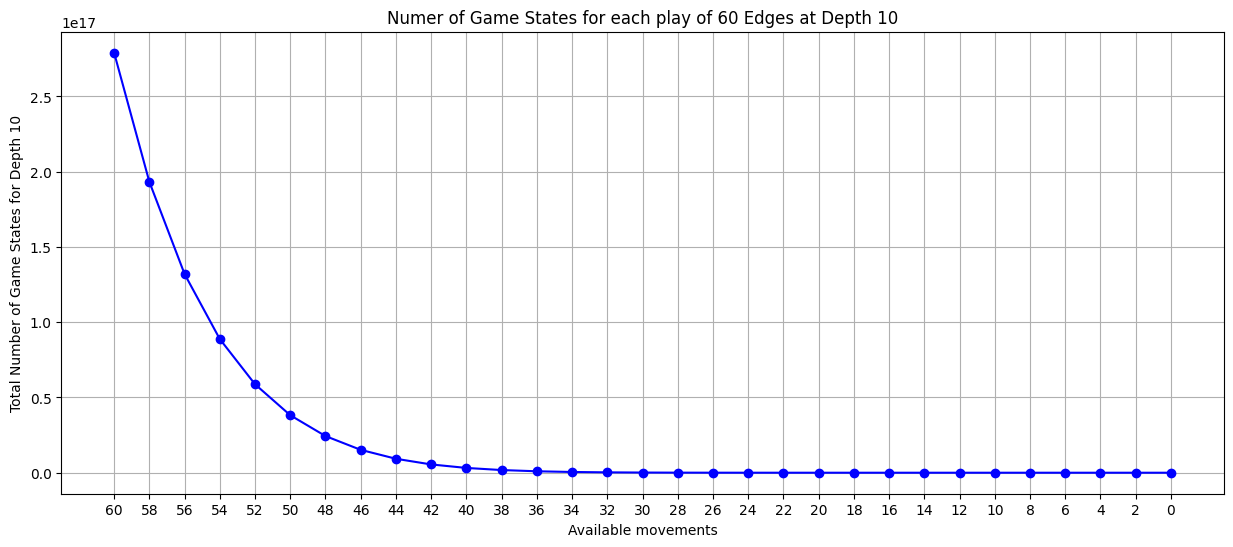

In [59]:
elements = range(0, N + 1, 2)
states = [total_states_depth(n, d) for n in elements]

plt.figure(figsize=(15, 6))
plt.plot(elements, states, marker='o', linestyle='-', color='b')
plt.gca().invert_xaxis()
plt.xlabel('Available movements')
plt.ylabel(f'Total Number of Game States for Depth {d}')
plt.title(f'Numer of Game States for each play of {N} Edges at Depth {d}')
plt.grid(True)
plt.xticks(elements)
plt.show()